In [1]:
import numpy as np
import torch
import torch.nn as nn
import pandas as pd
from sklearn import preprocessing
from sklearn.metrics import r2_score, mean_absolute_error
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import random
from pathlib import Path
import os
from datetime import datetime
import pickle

## Parameters

In [2]:
data_file = os.path.join(os.getcwd(), 'ERCOT_2022_Prepped.csv')

In [3]:
data_df = pd.read_csv(data_file, index_col=0)
data_df.index = pd.to_datetime(data_df.index)
data_df.columns

Index(['ERCOT_Demand_MWh', 'ERCOT_VRE_MWh', 'Hour', 'Month', 'Time_Elapsed',
       'delta_VRE', 'delta_Demand', 'delta_CO2', 'delta_NOx', 'delta_SO2'],
      dtype='object')

In [4]:
data_file = os.path.join(os.getcwd(), 'ERCOT_2022_Prepped.csv')
model_save_dir = os.path.join(os.getcwd(), "MLP_ERCOT_2022_models")
Path(model_save_dir).mkdir(parents=True, exist_ok=True)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
n_out = 3    # 3 output parameters: MEF, MDF, interecept. 
             # inclusion of intercept is debatable (we'd love to have a model where it is zero),
             # and so far it has not much impacted r^2.
             # once we do test train split i only want to keep it if it notably improves model accuracy
feature_cols = data_df.columns[:5]

In [5]:
device

device(type='cuda')

## Data Loading and pre-processing

In [6]:
data_df = pd.read_csv(data_file, index_col=0)
data_df.index = pd.to_datetime(data_df.index)

In [7]:
data_df.index[0]

Timestamp('2022-01-01 00:00:00')

In [8]:
len(data_df)

8760

In [9]:
num_samples = len(data_df)

# create masks for train, validation and test data
percent_train, percent_val, percent_test = .6, .2, .2
num_train, num_val = int(percent_train * num_samples), int(percent_val * num_samples)
num_test = num_samples - num_train - num_val
set_assignments = np.array([1 for i in range(num_train)] + [2 for i in range(num_val)] + [3 for i in range(num_test)])
np.random.seed(1)
np.random.shuffle(set_assignments)
train_mask = set_assignments == 1
val_mask = set_assignments == 2
test_mask = set_assignments == 3
train_df = data_df.loc[train_mask]
val_df = data_df.loc[val_mask]
test_df = data_df.loc[test_mask]

# specify x and y data #TODO seems like there may be some unnecessary operations here... 
train_x = torch.tensor(train_df[feature_cols].values.astype(np.float32))
val_x = torch.tensor(val_df[feature_cols].values.astype(np.float32))
test_x = torch.tensor(test_df[feature_cols].values.astype(np.float32))


# standardize data based on mean and variance of train data
scaler = preprocessing.StandardScaler()
scaler.fit(train_x)
train_x = torch.tensor(scaler.transform(train_x)).to(device)
val_x = torch.tensor(scaler.transform(val_x)).to(device)
test_x = torch.tensor(scaler.transform(test_x)).to(device)

# save scaler for later re-use
with open(os.path.join(model_save_dir, "scaler.pkl"), 'wb') as f:
    pickle.dump(scaler, f)

In [10]:
data_df.iloc[:5]

,ERCOT_Demand_MWh,ERCOT_VRE_MWh,Hour,Month,Time_Elapsed,delta_VRE,delta_Demand,delta_CO2,delta_NOx,delta_SO2
2022-01-01 00:00:00,37404.219075,12067.52,0,1,0,818.61,-1173.291650,-2.216431e+06,-295.373619,1387.534201
2022-01-01 01:00:00,36230.927425,12886.13,1,1,1,818.61,-1173.291650,-2.216431e+06,-295.373619,1387.534201
2022-01-01 02:00:00,35303.849625,14369.56,2,1,2,1483.43,-927.077800,-3.264976e+06,-2054.543547,-4280.112044
2022-01-01 03:00:00,34696.113600,16467.77,3,1,3,2098.21,-607.736025,-3.923160e+06,-1510.694028,-9461.452151
2022-01-01 04:00:00,34466.782550,18337.91,4,1,4,1870.14,-229.331050,-2.491853e+06,-1178.800561,-5160.397812


In [11]:
train_x.shape

torch.Size([5256, 5])

In [12]:
feature_cols

Index(['ERCOT_Demand_MWh', 'ERCOT_VRE_MWh', 'Hour', 'Month', 'Time_Elapsed'], dtype='object')

In [13]:
train_x[:,-1]

tensor([-1.7212, -1.7204, -1.7196,  ...,  1.7397,  1.7400,  1.7404],
       device='cuda:0', dtype=torch.float64)

## define model loss function

In [14]:
def get_model(n_input, hidden_dims, n_out, dropout_p):
    
    layers = [nn.Linear(n_input, hidden_dims[0]),
              nn.BatchNorm1d(hidden_dims[0]),
              nn.ReLU(),
              nn.Dropout(dropout_p)
             ]
    for layer in range(len(hidden_dims)-1):
        cur_hidden, next_hidden = hidden_dims[layer], hidden_dims[layer+1]
        layers.extend([nn.Linear(cur_hidden, next_hidden),
                       nn.BatchNorm1d(next_hidden),
                       nn.ReLU(),
                       nn.Dropout(dropout_p)
                      ])
    layers.append(nn.Linear(hidden_dims[-1], n_out))
    
    model = nn.Sequential(*layers)
    return model

# def mse_loss_regularized_preds_l2(pred_coeff, data_df, MEF_reg_weight, MDF_reg_weight, bias_term, target_col):
#     delta_load_tensor = torch.tensor(np.array(data_df['delta_Demand'].values).astype(np.float32))
#     delta_vre_tensor = torch.tensor(np.array(data_df['delta_VRE'].values).astype(np.float32))
#     MEF_preds = pred_coeff[:,0]
#     MDF_preds = pred_coeff[:,1]
#     pred_y_demand = torch.mul(delta_load_tensor, MEF_preds)
#     pred_y_vre = torch.mul(delta_vre_tensor, MDF_preds)
#     pred_y = pred_y_vre + pred_y_demand
#     if bias_term:
#         bias_preds = pred_coeff[:,2]
#         pred_y += bias_preds
#     act_y = torch.tensor(np.array(data_df[target_col].values).astype(np.float32))

#     # Compute MEF regularization term (sum(MEF^2 + intercept if MEF < 0 for MEF in examples))
#     invalid_MEFs = nn.functional.relu(-MEF_preds)  # keep negative MEFs and zero others
#     count_invalid_MEFs = torch.count_nonzero(invalid_MEFs)
#     MEF_reg_intercept = 4420  # based on an average value of -65 seen amongst invalids when trained without regularization
#     MEF_reg = torch.dot(invalid_MEFs, invalid_MEFs) + (count_invalid_MEFs * MEF_reg_intercept)

#     # Compute MDF regularization term (sum(MDF^2 + intercept if MDF > 0 for MDF in examples))
#     invalid_MDFs = nn.functional.relu(MDF_preds)  # keep negative MEFs and zero others
#     count_invalid_MDFs = torch.count_nonzero(invalid_MDFs)
#     MDF_reg_intercept = 538  # based on an average value of +23 seen amongst invalids when trained without regularization
#     MDF_reg = torch.dot(invalid_MDFs, invalid_MDFs) + (count_invalid_MDFs * MDF_reg_intercept)

#     loss = nn.MSELoss()(pred_y, act_y) + (MEF_reg_weight * MEF_reg) + (MDF_reg_weight * MDF_reg)
#     return loss

def mse_loss_regularized_preds_l1(pred_coeff, data_df, MEF_reg_weight, MDF_reg_weight, bias_term, target_col):
    intercept_scalings_by_target = {
        'delta_CO2': 1.0,
        'delta_NOx': 1.0 / 1000.0,
        'delta_SO2': 1.0 / 10000.0,
    }
    assert target_col in intercept_scalings_by_target
    intercept_scaling = intercept_scalings_by_target[target_col]
    
    delta_load_tensor = torch.tensor(np.array(data_df['delta_Demand'].values).astype(np.float32))
    delta_vre_tensor = torch.tensor(np.array(data_df['delta_VRE'].values).astype(np.float32))
    MEF_preds = pred_coeff[:,0]
    MDF_preds = pred_coeff[:,1]
    pred_y_demand = torch.mul(delta_load_tensor, MEF_preds)
    pred_y_vre = torch.mul(delta_vre_tensor, MDF_preds)
    pred_y = pred_y_vre + pred_y_demand
    if bias_term:
        bias_preds = pred_coeff[:,2]
        pred_y += bias_preds
    act_y = torch.tensor(np.array(data_df[target_col].values).astype(np.float32))

    # Compute MEF regularization term (sum(MEF + intercept if MEF < 0 for MEF in examples))
    invalid_MEFs = nn.functional.relu(-MEF_preds)  # keep negative MEFs and zero others
    count_invalid_MEFs = torch.count_nonzero(invalid_MEFs)
    MEF_reg_intercept = 66.5 * intercept_scaling  # The average value seen amongst invalids when trained without regularization
    MEF_reg = torch.sum(invalid_MEFs) + (count_invalid_MEFs * MEF_reg_intercept)

    # Compute MDF regularization term (sum(MDF + intercept if MDF > 0 for MDF in examples))
    invalid_MDFs = nn.functional.relu(MDF_preds)  # keep negative MEFs and zero others
    count_invalid_MDFs = torch.count_nonzero(invalid_MDFs)
    MDF_reg_intercept = 23.2 * intercept_scaling  # The average value seen amongst invalids when trained without regularization
    MDF_reg = torch.sum(invalid_MDFs) + (count_invalid_MDFs * MDF_reg_intercept)

    loss = nn.MSELoss()(pred_y, act_y) + (MEF_reg_weight * MEF_reg) + (MDF_reg_weight * MDF_reg)
    return loss

## Model Training

Helpers for printing results

In [15]:
pd.options.mode.chained_assignment = None  # default='warn'

In [16]:
def plot_losses(train_losses, val_losses, plt_save_dir=None):
    #plot loss vs epochs
    fig, axs = plt.subplots(1,2)
    axs[0].plot(train_losses[1000:])
    axs[0].set_title("Train Set")
    axs[0].set_ylabel('loss')
    axs[0].set_xlabel('epoch')

    axs[1].plot(val_losses[1000:])
    axs[1].set_title("Val Set")
    axs[1].set_ylabel('loss')
    axs[1].set_xlabel('epoch')
    
    plt.tight_layout()
    plt.show()
    
    if plt_save_dir:
        fig.savefig(os.path.join(plt_save_dir,"train_val_losses.png"))
        
def get_r_squared(pred_coeff, data_df, bias_term, target_col):
    coeff_df=pd.DataFrame(data=pred_coeff.detach().numpy(), columns=['MEF', 'MDF', 'Intercept'])
    y_preds = coeff_df['MEF'].values * data_df['delta_Demand'] \
                                   + coeff_df['MDF'].values * data_df['delta_VRE']
    if bias_term:
        y_preds += coeff_df['Intercept'].values
    r2 = r2_score(data_df[target_col], y_preds)
    return r2

def get_mean_abs_err(pred_coeff, data_df, bias_term, target_col):
    coeff_df=pd.DataFrame(data=pred_coeff.detach().numpy(), columns=['MEF', 'MDF', 'Intercept'])
    y_preds = coeff_df['MEF'].values * data_df['delta_Demand'] \
                                   + coeff_df['MDF'].values * data_df['delta_VRE']
    if bias_term:
        y_preds += coeff_df['Intercept'].values
    mean_abs_err = mean_absolute_error(data_df[target_col], y_preds)
    return mean_abs_err

def get_count_invalid_preds(pred_coeff):
    # preds=pred_coeff.detach().numpy()
    count_neg_MEFs = torch.sum(pred_coeff[:,0] <= 0).item() #sum(preds[:,0] <= 0) # MEF must be greater than 0
    count_pos_MDFs = torch.sum(pred_coeff[:,1] > 0).item() #sum(preds[:,1] > 0)  # MDF must be less than or equal to 0
    return count_neg_MEFs, count_pos_MDFs

Helper for training a model with a given set of hyperparameters and saving the best model and results

In [17]:
def train_model_with_params(train_x, val_x, train_df, val_df,
                            n_out, hidden_dims, learning_rate, weight_decay, dropout_p,
                            loss_function, MEF_reg_weight, MDF_reg_weight, bias_term,
                            target_col,
                            model_dir_prefix=None, epochs=10000, min_save_r2=.87):
    
    n_input = train_x.shape[1]
    model = get_model(n_input, hidden_dims, n_out, dropout_p)
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    model_dir = model_save_dir
    if model_dir_prefix:
        model_dir = os.path.join(model_dir, model_dir_prefix)
    model_dir = os.path.join(model_dir, str(datetime.now().strftime('%Y_%m_%d-%I_%M_%S_%p')))
    Path(model_dir).mkdir(parents=True, exist_ok=True)
    
    # log experiment settings
    settings_str = "Model Settings:"
    settings_str += f"\n\t{n_input=}\n\t{hidden_dims=}\n\t{n_out=}\n\t{dropout_p=}\n\t{bias_term=}"
    settings_str += "\nOptimizer Settings:"
    settings_str += f"\n\t{learning_rate=}\n\t{weight_decay=}"
    settings_str += "\nLoss Function Settings:"
    settings_str += f"\n\t{loss_function=}\n\t{MEF_reg_weight=}\n\t{MDF_reg_weight=}"
    settings_str += "\nTrain Process Settings:"
    settings_str += f"\n\t{epochs=}\n\t{min_save_r2=}"
    settings_str += f"\nFeatures: {', '.join(feature_cols)}"
    settings_str += f"\Target_col: {target_col}"
    print(settings_str)
    with open(os.path.join(model_dir, "experiment_settings.txt"), 'w+') as f:
        f.write(settings_str)
        
    model.to(device)

    best_r2 = -np.inf 
    best_epoch = None
    save_model_path = None
    last_save_epoch = None
    last_save_r2 = -np.inf
    last_save_mae = np.inf
    
    train_losses = []
    val_losses = []
    for epoch in tqdm(range(epochs)):
        # tell model we are training (for bathnorm layer, dropout...)
        model.train()
        train_pred_coeff=model(train_x.float()).cpu()
        train_loss=loss_function(train_pred_coeff, train_df, MEF_reg_weight, MDF_reg_weight, bias_term, target_col)
        train_losses.append(train_loss.item())
        
        # tell model we are evaluating
        model.eval()
        val_pred_coeff=model(val_x.float()).cpu()
        val_loss=loss_function(val_pred_coeff, val_df, MEF_reg_weight, MDF_reg_weight, bias_term, target_col)
        val_losses.append(val_loss.item())
        val_r2 = get_r_squared(val_pred_coeff, val_df, bias_term, target_col)

        # always keep best r2 updated
        if val_r2 > best_r2:
            best_r2 = val_r2
            best_epoch = epoch
        # check if we should save... we need good enough r2 and no invalids
        if val_r2 > max(last_save_r2, min_save_r2):
            if sum(get_count_invalid_preds(val_pred_coeff))==0:
                # also check training invalids... Let's recompute with eval mode
                model.eval()
                eval_mode_train_preds=model(train_x.float()).cpu()
                if sum(get_count_invalid_preds(eval_mode_train_preds))==0:
                    if save_model_path:
                        Path(save_model_path).unlink() # delete prev-best model
                    model_save_name = f"epoch={epoch},r2={val_r2:.4f},Invalids=0.pth"
                    save_model_path = os.path.join(model_dir, model_save_name)
                    torch.save(model.state_dict(), save_model_path)
                    last_save_epoch = epoch
                    last_save_r2 = val_r2
                    last_save_mae = get_mean_abs_err(val_pred_coeff, val_df, bias_term, target_col)

        
        if epoch % 1000 == 0:
            invalid_train_MEFs, invalid_train_MDFs = get_count_invalid_preds(train_pred_coeff)
            invalid_val_MEFs, invalid_val_MDFs = get_count_invalid_preds(val_pred_coeff)
            train_r2 = get_r_squared(train_pred_coeff, train_df, bias_term, target_col)
            # val_r2 = get_r_squared(val_pred_coeff, val_df, bias_term, target_col)
            print(f"[Epoch {epoch}]")
            print(f"\tTrain Set: Loss={train_loss.item():.3e}, R Squared={train_r2:.4f}, Invalid MEFs={invalid_train_MEFs}, Invalid MDFs={invalid_train_MDFs}")
            print(f"\tVal Set: Loss={val_loss.item():.3e}, R Squared={val_r2:.4f}, Invalid MEFs={invalid_val_MEFs}, Invalid MDFs={invalid_val_MDFs}")
        model.zero_grad()
        train_loss.backward()
        optimizer.step()
        # stop if we aren't improving after 10k epochs
        if best_epoch and epoch > 10000 + best_epoch:
            print("Early stopping as we haven't made an improvement on validation set in 10,000 epochs.")
            break
        
    plot_losses(train_losses, val_losses, model_dir)

    results_str = f"Best R Squared seen on epoch {best_epoch}: {best_r2:.4f}"
    results_str += f"\nBest-R2-model with R2 above {min_save_r2=} and 0 invalid coefficients predicted on train/test sets:"
    if not save_model_path:
        results_str += f"\n\tNo such model was encountered"
    else:
        results_str += f"\n\tValidation R2: {last_save_r2:.4f}"
        results_str += f"\n\tValidation MAE: {last_save_mae:.2f}"
        results_str += f"\n\tEpoch seen: {last_save_epoch}"
        results_str += f"\n\tModel file: {save_model_path.split('/')[-1]}"

    print(results_str)
    with open(os.path.join(model_dir, "results.txt"), 'w+') as f:
        f.write(results_str)
        
    return save_model_path

# Predicting delta SO2

### Train with varying hyperparams

Model Settings:
	n_input=5
	hidden_dims=[256, 128]
	n_out=3
	dropout_p=0.5
	bias_term=True
Optimizer Settings:
	learning_rate=0.001
	weight_decay=0.03
Loss Function Settings:
	loss_function=<function mse_loss_regularized_preds_l1 at 0x0000023E887194C0>
	MEF_reg_weight=10000.0
	MDF_reg_weight=10000.0
Train Process Settings:
	epochs=60000
	min_save_r2=0.35
Features: ERCOT_Demand_MWh, ERCOT_VRE_MWh, Hour, Month, Time_Elapsed\Target_col: delta_SO2


  0%|          | 0/60000 [00:00<?, ?it/s]

[Epoch 0]
	Train Set: Loss=1.921e+07, R Squared=-0.5856, Invalid MEFs=2986, Invalid MDFs=500
	Val Set: Loss=4.414e+06, R Squared=-0.0253, Invalid MEFs=1263, Invalid MDFs=0
[Epoch 1000]
	Train Set: Loss=1.947e+06, R Squared=0.3232, Invalid MEFs=3, Invalid MDFs=1
	Val Set: Loss=2.195e+06, R Squared=0.2998, Invalid MEFs=0, Invalid MDFs=0
[Epoch 2000]
	Train Set: Loss=1.900e+06, R Squared=0.3396, Invalid MEFs=3, Invalid MDFs=3
	Val Set: Loss=2.164e+06, R Squared=0.3098, Invalid MEFs=0, Invalid MDFs=0
[Epoch 3000]
	Train Set: Loss=1.848e+06, R Squared=0.3580, Invalid MEFs=7, Invalid MDFs=2
	Val Set: Loss=2.125e+06, R Squared=0.3220, Invalid MEFs=0, Invalid MDFs=0
[Epoch 4000]
	Train Set: Loss=1.774e+06, R Squared=0.3836, Invalid MEFs=5, Invalid MDFs=1
	Val Set: Loss=2.082e+06, R Squared=0.3359, Invalid MEFs=0, Invalid MDFs=0
[Epoch 5000]
	Train Set: Loss=1.716e+06, R Squared=0.4039, Invalid MEFs=10, Invalid MDFs=1
	Val Set: Loss=2.042e+06, R Squared=0.3485, Invalid MEFs=0, Invalid MDFs=0
[E

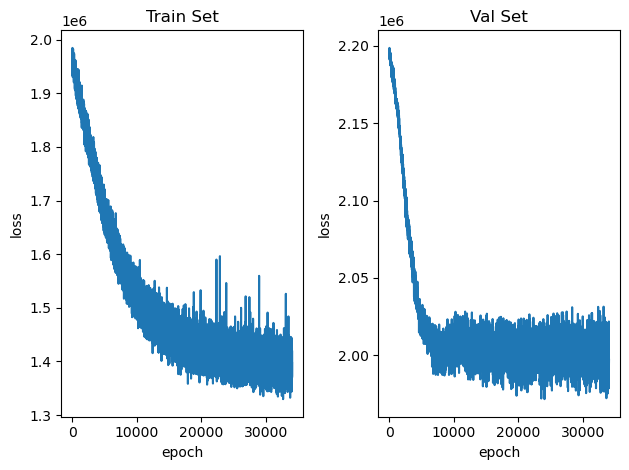

Best R Squared seen on epoch 25049: 0.3711
Best-R2-model with R2 above min_save_r2=0.35 and 0 invalid coefficients predicted on train/test sets:
	Validation R2: 0.3711
	Validation MAE: 973.88
	Epoch seen: 25049
	Model file: C:\Users\nicklein\Documents\MEF-Regression\MLP_ERCOT_2022_models\delta_SO2_round1\2023_11_01-10_32_30_AM\epoch=25049,r2=0.3711,Invalids=0.pth


'C:\\Users\\nicklein\\Documents\\MEF-Regression\\MLP_ERCOT_2022_models\\delta_SO2_round1\\2023_11_01-10_32_30_AM\\epoch=25049,r2=0.3711,Invalids=0.pth'

In [25]:
target_col = 'delta_SO2'
hidden_dims = [256,128]
lr = .001
weight_decay = .03
dropout_p = 0.5
bias_term = True
reg_weights = [1e4, 1e4]
loss_function = mse_loss_regularized_preds_l1
save_prefix = f'{target_col}_round1'

train_model_with_params(train_x, val_x, train_df, val_df, n_out, hidden_dims, lr, weight_decay, dropout_p,
                                            loss_function, *reg_weights, bias_term, target_col, save_prefix, epochs=60000, min_save_r2=.35)

## Inference on all data

In [27]:
model_save_dir

'C:\\Users\\nicklein\\Documents\\MEF-Regression\\MLP_ERCOT_2022_models'

In [26]:
best_model_dir = os.path.join(model_save_dir, "delta_SO2_round1\\2023_11_01-10_20_25_AM")
best_model_file = os.path.join(best_model_dir, "epoch=36980,r2=0.3815,Invalids=0.pth")

In [28]:
best_model_file

'C:\\Users\\nicklein\\Documents\\MEF-Regression\\MLP_ERCOT_2022_models\\delta_SO2_round1\\2023_11_01-10_20_25_AM\\epoch=36980,r2=0.3815,Invalids=0.pth'

In [30]:
hidden_dims = [256,256]
bias_term = True
dropout_p = 0.5
n_input = train_x.shape[1]

model = get_model(n_input, hidden_dims, n_out, dropout_p)
model.to(device)
model.load_state_dict(torch.load(best_model_file))
model.eval()

train_pred_coeff = model(train_x.float()).cpu()
val_pred_coeff = model(val_x.float()).cpu()
test_pred_coeff = model(test_x.float()).cpu()

results_str = "R Squared:"
results_str += f"\n\tTrain: {get_r_squared(train_pred_coeff, train_df, bias_term, target_col):.4f}"
results_str += f"\n\tVal: {get_r_squared(val_pred_coeff, val_df, bias_term, target_col):.4f}"
results_str += f"\n\tTest: {get_r_squared(test_pred_coeff, test_df, bias_term, target_col):.4f}"
results_str += "\nMean Absolute Error:"
results_str += f"\n\tTrain: {get_mean_abs_err(train_pred_coeff, train_df, bias_term, target_col):.2f}"
results_str += f"\n\tVal: {get_mean_abs_err(val_pred_coeff, val_df, bias_term, target_col):.2f}"
results_str += f"\n\tTest: {get_mean_abs_err(test_pred_coeff, test_df, bias_term, target_col):.2f}"
results_str += "\nCount Invalid Values Predicted:"
invalid_train_MEFs, invalid_train_MDFs = get_count_invalid_preds(train_pred_coeff)
invalid_val_MEFs, invalid_val_MDFs = get_count_invalid_preds(val_pred_coeff)
invalid_test_MEFs, invalid_test_MDFs = get_count_invalid_preds(test_pred_coeff)
results_str += f"\n\tTrain: Invalid MEFs={invalid_train_MEFs}, Invalid MDFs={invalid_train_MDFs}"
results_str += f"\n\tVal: Invalid MEFs={invalid_val_MEFs}, Invalid MDFs={invalid_val_MDFs}"
results_str += f"\n\tTest: Invalid MEFs={invalid_test_MEFs}, Invalid MDFs={invalid_test_MDFs}"

with open(os.path.join(best_model_dir, "eval_results.txt"), 'w+') as f:
    f.write(results_str)
print(results_str)

R Squared:
	Train: 0.5706
	Val: 0.3815
	Test: 0.3877
Mean Absolute Error:
	Train: 787.85
	Val: 963.52
	Test: 1018.73
Count Invalid Values Predicted:
	Train: Invalid MEFs=0, Invalid MDFs=0
	Val: Invalid MEFs=0, Invalid MDFs=0
	Test: Invalid MEFs=0, Invalid MDFs=0


### Put the MEFs and MDFs from all sets back together and in order into the original DF for viewing

In [31]:
all_preds_w_timestamps = list(zip(val_df.index, val_pred_coeff.detach().numpy())) \
                        + list(zip(train_df.index, train_pred_coeff.detach().numpy())) \
                        + list(zip(test_df.index, test_pred_coeff.detach().numpy()))
all_preds_w_timestamps.sort(key=lambda pair: pair[0])
all_preds_ordered = np.array([pair[1] for pair in all_preds_w_timestamps])

In [32]:
all_MEFs_ordered = all_preds_ordered[:,0]
all_MDFs_ordered = all_preds_ordered[:,1]
all_intercepts_ordered = all_preds_ordered[:,2]

In [33]:
data_df.loc[:,"MEF"] = all_MEFs_ordered
data_df.loc[:,"MDF"] = all_MDFs_ordered
if bias_term:
    data_df.loc[:,"Intercept"] = all_intercepts_ordered

#calculate some error stuff. rn i am thinking R2 is the best measure of error
d_emissions = data_df.loc[:,'MEF'] * data_df.loc[:,'delta_Demand'] \
            + data_df.loc[:,'MDF'] * data_df.loc[:,'delta_VRE']
if bias_term:
    d_emissions += data_df.loc[:,"Intercept"]
    
pred_col = f'Predicted_{target_col}'
data_df.loc[:, pred_col] = d_emissions
data_df.loc[:,'Error']=data_df.loc[:, pred_col] - data_df.loc[:, target_col]
data_df.loc[:,'%_Error']=np.abs(data_df.loc[:,'Error'])/np.abs(data_df.loc[:, target_col]) * 100
print("Whole Data Set:")
print(f"\tMean Emissions Change = {np.mean(np.abs(data_df[target_col])):.2f}")
print(f"\tR Squared = {r2_score(data_df[target_col], data_df[pred_col]):.4f}")
print(f"\tMean Absolute Error = {mean_absolute_error(data_df[target_col], data_df[pred_col]):.2f}")

Whole Data Set:
	Mean Emissions Change = 1155.77
	R Squared = 0.4902
	Mean Absolute Error = 869.16


Add train/val/test set assignments to table before saving

In [34]:
set_assignments

array([1, 2, 1, ..., 1, 1, 1])

In [35]:
set_num_to_str = {1: 'train',
                  2: 'validation',
                  3: 'test'
                 }

In [36]:
data_df.loc[:,'set_assignment'] = [set_num_to_str[num] for num in set_assignments]

In [37]:
all(test_df.index == data_df.loc[data_df.loc[:,'set_assignment'] == 'test'].index)

True

In [38]:
data_df.head()

,ERCOT_Demand_MWh,ERCOT_VRE_MWh,Hour,Month,Time_Elapsed,delta_VRE,delta_Demand,delta_CO2,delta_NOx,delta_SO2,MEF,MDF,Intercept,Predicted_delta_SO2,Error,%_Error,set_assignment
2022-01-01 00:00:00,37404.219075,12067.52,0,1,0,818.61,-1173.291650,-2.216431e+06,-295.373619,1387.534201,0.151913,-0.628880,-61.742455,-754.788687,-2142.322887,154.397844,train
2022-01-01 01:00:00,36230.927425,12886.13,1,1,1,818.61,-1173.291650,-2.216431e+06,-295.373619,1387.534201,0.264206,-0.818516,-149.409714,-1129.445264,-2516.979465,181.399454,validation
2022-01-01 02:00:00,35303.849625,14369.56,2,1,2,1483.43,-927.077800,-3.264976e+06,-2054.543547,-4280.112044,0.668802,-1.417619,-239.824600,-2962.794856,1317.317188,30.777633,train
2022-01-01 03:00:00,34696.113600,16467.77,3,1,3,2098.21,-607.736025,-3.923160e+06,-1510.694028,-9461.452151,0.776881,-1.528058,-309.996704,-3988.321803,5473.130348,57.846621,validation
2022-01-01 04:00:00,34466.782550,18337.91,4,1,4,1870.14,-229.331050,-2.491853e+06,-1178.800561,-5160.397812,0.739888,-1.553361,-304.892731,-3379.574311,1780.823501,34.509423,train


In [39]:
data_df.to_csv(os.path.join(best_model_dir, "ercot_2022.so2_preds.csv"))

In [40]:
len([val for val in data_df.loc[:,"MEF"] if val <=0])

0

In [41]:
len([val for val in data_df.loc[:,"MEF"] if val >600])

0

In [42]:
data_df.loc[:,"MEF"].max()

2.3171439170837402

In [43]:
len([val for val in data_df.loc[:,"MDF"] if val < -600])

0

In [44]:
data_df.loc[:,"MDF"].min()

-3.0336296558380127

In [45]:
data_df.loc[:,['MEF','MDF','Intercept','%_Error']].describe()

,MEF,MDF,Intercept,%_Error
count,8760.000000,8760.000000,8760.000000,8760.000000
mean,0.369058,-0.278705,-20.755564,358.312261
std,0.281124,0.263410,108.626419,6148.993493
min,0.036636,-3.033630,-464.913696,0.017936
25%,0.163061,-0.366239,-82.013067,48.730343
50%,0.290640,-0.189559,-9.301927,84.453978
75%,0.491275,-0.095239,41.303488,134.923993
max,2.317144,-0.019608,391.842560,436063.596793
